# Summary
This notebook defines The CATIE [1] model and then optimizes a static and dynamic reward schedule as defined in the choice engineering competition [2]. The general model of CAITE is implemented here for the specific context of the competition, that is a sequence of 100 choices between two alternatives that each yield 25 binary rewards ("1") and 75 trials without reward ("0").



---
[1] Plonsky, Ori, and Ido Erev. "Learning in settings with partial feedback and the wavy recency effect of rare events." Cognitive Psychology 93 (2017): 18-43.

[2] Dan, Ohad, and Yonatan Loewenstein. "From choice architecture to choice engineering." Nature communications 10.1 (2019): 1-4.

# Define CATIE model

Imports:

In [ ]:
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Model constants:

In [ ]:
REWARDS_PER_SEQ = 25

PHI = 0.71
TAU = 0.29
EPSILON = 0.3

CHOICE_BIASED = 1
CHOICE_ANTI_BIASED = -1

Helper functions

In [ ]:
def choose_randomly():
  """ Return either of the alternatives with 50% chance """
  if random.random() < 0.5:
      choice = CHOICE_BIASED
  else:
      choice = CHOICE_ANTI_BIASED
  return choice


def other_alternative(a):
  """
  Given alternative a return the other alternative:
    CHOICE_BIASED --> CHOICE_ANTI_BIASED
    CHOICE_ANTI_BIASED --> CHOICE_BIASED
  """
  if a is CHOICE_BIASED:
      return CHOICE_ANTI_BIASED
  if a is CHOICE_ANTI_BIASED:
      return CHOICE_BIASED

## Define the CATIE class

Helper constant - **Trend**

The model defines three types of outcome "trends":


1. ***Invalid*** - Trend is only defined if the same alternative has been chosen twice in a sequence; if this is not the case, current trend is not defined (here, termed "invalid").
1. ***Positive*** - the outcomes of current and previous choices were of the same alternative and the previous outcome (at t-1) exceeds that of the trial before it (at t-2).
1. ***Negative*** - the outcomes of current and previous choices were of the same alternative and the previous outcome (at t-1) does not exceed that of the trial before it (at t-2).



In [ ]:
class Trend:
  ''' Assign a numerical representation to each of the trend types '''
  POSITIVE = 1
  NON_POSITIVE = -1
  INVALID = 0

Class implementation:

In [ ]:
class CatieAgent:
    def __init__(self, K=2):
        self.tau = TAU
        self.phi = PHI
        self.epsilon = EPSILON
        self.K = K
        self.k= random.randint(0, K)
        self.trial_number = 0
        self.choices = []
        self.surprises = []
        self.outcomes = []
        self.outcomes_biased = []
        self.outcomes_anti_biased = []

    def get_p_explore(self):
      if len(self.surprises)==0:
        p_explore = self.epsilon*1/3
      else:
        p_explore = self.epsilon*(1 + self.surprises[-1] + statistics.mean(self.surprises))/3
      return p_explore

    def get_trend(self):
      '''
      Probability for entering Explore mode
      '''
      if (len(self.choices)<2 or
          self.choices[-1] != self.choices[-2]):
        trend = Trend().INVALID
      elif self.outcomes[-1] > self.outcomes[-2]:
        trend = Trend().POSITIVE
      else:
        trend = Trend().NON_POSITIVE
      return trend

    def choose(self):
      '''
      Return a single choice based on current state using the four decision
      modes.
      '''
        # On the first two trials, choose randomly
      if self.trial_number == 0:
        choice = random.choice([CHOICE_BIASED, CHOICE_ANTI_BIASED])
      elif self.trial_number == 1:
        if self.choices[0] == CHOICE_BIASED:
          choice = CHOICE_ANTI_BIASED
        elif self.choices[0] == CHOICE_ANTI_BIASED:
          choice = CHOICE_BIASED
      else:
      # Trend/Heuristic mode
        if ((self.choices[-1] == self.choices[-2]) and # if the same alternative was chosen in the last two trials
            (self.outcomes[-1] != self.outcomes[-2]) and # and it had different outcomes
            (random.random() < self.tau)):  # enter heuristic mode with probability phi
      # If there is a positive trend, continue choosing the same alternative, if not switch
          if self.outcomes[-1] > self.outcomes[-2]:
            choice = self.choices[-1]
          else:
            choice = other_alternative(self.choices[-1])
      # Explore mode
        elif random.random() < self.get_p_explore():
          choice = choose_randomly()
      # Inertia mode
        elif random.random() < self.phi:
          choice = self.choices[-1]
      # Contingent average mode
        else:
          ca_biased = self.__contingent_average(self.k, CHOICE_BIASED)
          ca_anti_biased = self.__contingent_average(self.k, CHOICE_ANTI_BIASED)
          if (ca_biased == ca_anti_biased or
            ca_biased is None or ca_anti_biased is None):
              choice = choose_randomly()
          elif ca_biased > ca_anti_biased:
              choice = CHOICE_BIASED
          elif ca_biased < ca_anti_biased:
              choice = CHOICE_ANTI_BIASED
      return choice

    def __contingent_average_specific_contingency(self, k, alternative, contingency):
        '''
        Return the alternative's contingent average or None if it has now contingencies.
        '''
        ca_outcomes = []
        for i in range(len(self.outcomes) - k):
            if (self.outcomes[i:i + k] == contingency) and (self.choices[i + k] == alternative):
                ca_outcomes.append(self.outcomes[i + k])
        return ca_outcomes

    def __contingent_average(self, k, alternative):
      '''
      The contingent average of the input alternative.
      '''
      if k == 0:
        ca_outcomes = self.outcomes_biased if alternative == CHOICE_BIASED else self.outcomes_anti_biased
      else:
        current_contingency = self.outcomes[-k:]
        ca_outcomes = self.__contingent_average_specific_contingency(k, alternative, current_contingency)
        if not ca_outcomes:  # If there aren't any contingencies like the current one
          alternative_choice_indices = [i for i in range((k-1), len(self.choices)) if self.choices[i] == alternative]
          all_k_contingencies = [self.outcomes[i:i+k] for i in alternative_choice_indices]
          if alternative_choice_indices:
            ca_outcomes = self.__contingent_average_specific_contingency(k, alternative, random.choice(all_k_contingencies))
          else:
            ca_outcomes = self.__contingent_average(k - 1, alternative)
      if not ca_outcomes:  # If there aren't any outcomes of the current
                            # alternative
        return None
      else:
        return statistics.mean(ca_outcomes)

    def get_contingent_average(self):
      '''
      Return the contingent average of both alterhatives.
      '''
      return (self.__contingent_average(self.k, CHOICE_BIASED),
              self.__contingent_average(self.k, CHOICE_ANTI_BIASED))

    def receive_outcome(self, choice, outcome):
      '''
      Updated internal state for receiving the input outcome as the result of
      choosing the input choice.
      '''
      self.choices.append(choice)
      self.outcomes.append(outcome)
      if choice == CHOICE_BIASED:
        obs_sd = 0 if len(self.outcomes_biased) < 2 else statistics.stdev(self.outcomes_biased) # stddv is only defined for2 or more numbers
        self.outcomes_biased.append(outcome)
      elif choice == CHOICE_ANTI_BIASED:
        obs_sd = 0 if len(self.outcomes_anti_biased) < 2 else statistics.stdev(self.outcomes_anti_biased)
        self.outcomes_anti_biased.append(outcome)
      if obs_sd > 0:
        exp_t_i = self.__contingent_average(self.k, choice)
        if exp_t_i is None:
          surprise_t = 0
        else:
          expected_actual_reward_diff = abs(exp_t_i-outcome)
          surprise_t = expected_actual_reward_diff/(obs_sd + expected_actual_reward_diff)
      else:
        surprise_t = 0
      self.surprises.append(surprise_t)
      self.trial_number += 1


# Test reward schedules on the model

Calculate average bias for a given sequence


In [ ]:
def sequence_catie_score(reward_schedule,
                                      repetitions=100, plot_distribution=False,
                         plot_sequence=False):
  schedule_target, schedule_anti_target = reward_schedule[0], reward_schedule[1]
  biases = []
  for i in range(repetitions):
    catie_agent = CatieAgent()
    choices = []
    for reward_targe, reward_anti_target in zip(
        schedule_target, schedule_anti_target):
      choice = catie_agent.choose()
      outcome = reward_targe if choice==CHOICE_BIASED else reward_anti_target
      catie_agent.receive_outcome(choice, outcome)
      choices.append(choice)
    biases.append(choices.count(CHOICE_BIASED))
  if plot_sequence:
    plt.plot([i+1 for i in range(100) if reward_schedule[0][i]], 2*np.ones(25),'x')
    plt.plot([i+1 for i in range(100) if reward_schedule[1][i]], np.ones(25),'x')
    plt.ylim([0.5, 2.5])
    plt.xlabel('Trial number')
    plt.ylabel('Is reward')
    plt.yticks([1,2], ['Anti side', 'Target side'])
  if plot_distribution:
    plt.figure()
    plt.hist(biases, alpha=0.5, density=True)
    plt.ylabel('Probability')
    plt.xlabel('Bias')
    plt.axvline(statistics.mean(biases), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(statistics.mean(biases)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(statistics.mean(biases)))
  return biases, statistics.mean(biases)

## Random sequence (sanity check)

Average bias should be ~50

Text(56.15896000000001, 0.09041181364392693, 'Mean: 51.05')

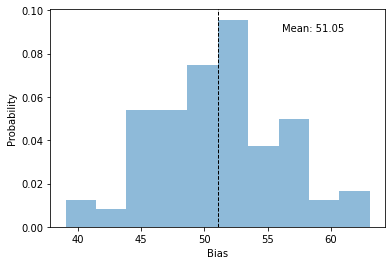

In [ ]:
def valid_one_side_allocation(shuffle=False):
  valid_seq = np.concatenate((np.zeros(75),np.ones(25)))
  if shuffle:
    np.random.shuffle(valid_seq)
  return valid_seq

def random_valid_sequence():
  return valid_one_side_allocation(True), valid_one_side_allocation(True)

NUMBER_OF_RANDOM_SEQ = 100
REPETITIONS_PER_SEQ = 50

random_seq_mean_biases = [sequence_catie_score(random_valid_sequence(), REPETITIONS_PER_SEQ)[1] for i in range(NUMBER_OF_RANDOM_SEQ)]
plt.hist(random_seq_mean_biases, alpha=0.5, density=True)
plt.ylabel('Probability')
plt.xlabel('Bias')
plt.axvline(statistics.mean(random_seq_mean_biases), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(statistics.mean(random_seq_mean_biases)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(statistics.mean(random_seq_mean_biases)))

## Score of optimized Q-learning (with parmeters fitted to the competition data)

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))


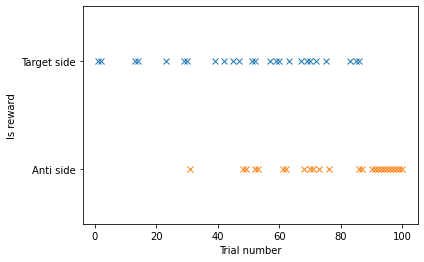

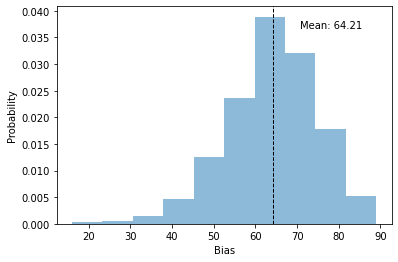

In [ ]:
ql_fit_het = np.array([1.,1.,0.,0.,0.,0.,0.,0.,0.,1.,1.,0.,0.,1.,0.,0.,1.,1.,0.,0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,1.,0.,0.,0.,1.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,1.,0.,1.,1.,0.,0.,1.,0.,0.,0.,1.,0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,0.,0.,0.]), np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,1.,0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,1.,0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.,1.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,1.,0.,0.,0.,0.,0.,1.,1.,0.,0.,0.,0.,0.,1.,0.,1.,0.,0.,0.,0.,0.,1.,0.,1.,1.,0.,1.,0.,1.,0.,1.,1.,1.])
ql_fit_hom = np.array([1.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,1.,0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,1.,1.,0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,0.,1.,0.,0.,1.,0.,1.,0.,0.,0.,1.,1.,0.,0.,0.,0.,1.,0.,1.,1.,0.,0.,1.,0.,0.,0.,1.,0.,1.,1.,0.,1.,0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,1.,0.,1.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]), np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,0.,0.,0.,0.,0.,1.,1.,0.,0.,0.,0.,0.,1.,0.,1.,1.,0.,1.,0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,1.,0.,0.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])

mean_bias_ql_fit_hom = sequence_catie_score(ql_fit_hom, 1000, True, True)[1]
print(ql_fit_hom)

# Optimize static sequence


## Define a valid CATIE sequence




In [ ]:
def catie_naive_optimization_seq():
  target_side = np.concatenate((np.ones(25),np.zeros(75)))
  anti_target_side = np.concatenate((np.zeros(75),np.ones(25)))
  return target_side, anti_target_side


## Optimization
Plonsky suggests manually defining that *k* of the first choices in the target side are manually set to provide reward.

### Helper functions

In [ ]:
K = 5

indices_for_shuffle_target = list(range(K,100))
indices_for_shuffle_anti_target = list(range(0,100))


def reshuffle_k_random_elements(v, num_elm_shuffle, indices_for_shuffle):
  random.shuffle(indices_for_shuffle_target)
  random_elements_indices = indices_for_shuffle_target[0:num_elm_shuffle]
  random_elements_indices_reshuffled = random_elements_indices.copy()
  random.shuffle(random_elements_indices_reshuffled)
  v[random_elements_indices] = v[random_elements_indices_reshuffled]

def mutate(seq, num_elm_shuffle):
  '''
  Reshuffle (in place) the value of num_elm_shuffle indices in:
    a. All elements of the target alternative, sparing the first K
    b. All elements of the target alternative
  '''
  seq = np.copy(seq)
  reshuffle_k_random_elements(seq[0], num_elm_shuffle, indices_for_shuffle_target)
  reshuffle_k_random_elements(seq[1], num_elm_shuffle, indices_for_shuffle_anti_target)
  return seq

### Optimize
Optimize a static sequence following the procedure described in the [supplementary](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-10825-6/MediaObjects/41467_2019_10825_MOESM1_ESM.pdf) of the "from choice architecture to choice engineering" paper.

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))


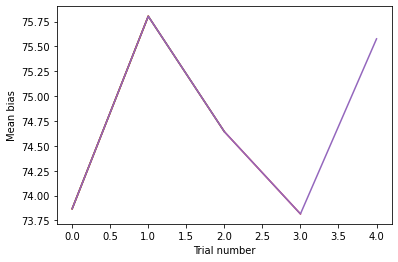

In [ ]:
# Optimization contstnats
IS_STATIC_OPTIMIZATION_DEBUG = True
if IS_STATIC_OPTIMIZATION_DEBUG:
  OPTIMIZATION_TRIALS = 5
  GENERATION_SIZE = 2
else:
  OPTIMIZATION_TRIALS = 120
  GENERATION_SIZE = 8

INITIAL_NUMBER_RESHUFLLE_ELEMETNS = 60

number_elemetns_to_reshufle_per_iteration = np.floor(np.linspace(INITIAL_NUMBER_RESHUFLLE_ELEMETNS, 2, num=OPTIMIZATION_TRIALS))
repetitions_for_score_calculation_per_iteration = np.floor(np.linspace(30, 300, num=OPTIMIZATION_TRIALS))

sequences = [catie_naive_optimization_seq() for i in range(GENERATION_SIZE)]
best = catie_naive_optimization_seq()
mean_biases = []
# Runt the static optimization iteratively
for ii in range(OPTIMIZATION_TRIALS):
  repetition_per_sequence = int(repetitions_for_score_calculation_per_iteration[ii])
  sequences_score = [sequence_catie_score(sequence, repetition_per_sequence)[1] for sequence in sequences]
  mean_biases.append(max(sequences_score))
  best = sequences[np.argmax(sequences_score)]
  num_elements_to_shuffle = int(number_elemetns_to_reshufle_per_iteration[ii])
  sequences = [best] + [random_valid_sequence()] + [mutate(best, num_elements_to_shuffle) for i in range(GENERATION_SIZE-1)]

  plt.plot(mean_biases)
  plt.xlabel('Trial number')
  plt.ylabel('Mean bias')
  plt.draw()

print(best)












## Score of optimized
Test the performance of the potimized sequence vs. the "naive optimal" (25 rewards at the beginning of the target and at the end of the anti target).
As sanity check, test the bias distribution of sending the optimized sequence where the target is anti targer and vice versa (should be symmetric around 50).

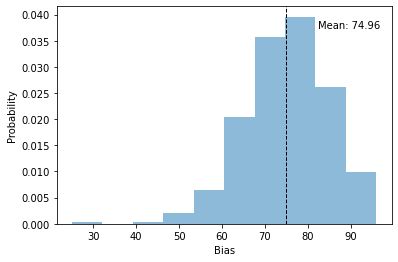

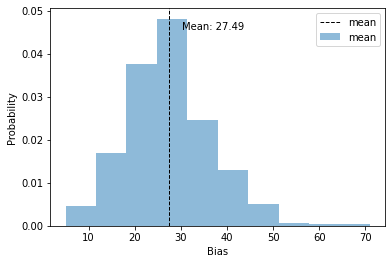

In [ ]:
optimized_switched = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
  0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
  0., 1., 1., 1.]),np.array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
  0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
  0., 0., 0., 0.,])
optimized = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
  1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  0., 0., 0., 0.,]),np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
  1., 1., 1., 1.])


mean_bias_optimized = sequence_catie_score(optimized, 1000, True)[1]
mean_bias_optimized_switched = sequence_catie_score(optimized_switched, 1000, True)[1]
plt.legend(('mean','mean','Optimized','Optimized switch'))

# Optimize Dynamic mechanism


## Define neural network

In [ ]:
import numpy as np
# Network constants
L0_SIZE = 9 # Number of input neurons (reflecting current state, don't change)
L_MIDDLE_SIZE = 100 # Number of neurons per each of the middle layers (arbitrary, can be changed)
N_MIDDLE_LAYERS = 4 # Arbitrary, can be changed
L_END_SIZE = 4 # Number of nerurons in the output layer, corresponding to the number of possible decisions (don't change)

WEIGHTS_INITAL_VALUE_NORMALZIATION = 1/10 # The greater the number, the greater is the mutation rate of each generation
NEURON_TO_ACTION = {0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1)}
INVALID_VALUE = -1 # Invalid / nonexistent
NO_PREVIOUS_CHOICE = 0

def random_weights(n_in, n_out):
  return (np.random.rand(n_in, n_out)-0.5)*WEIGHTS_INITAL_VALUE_NORMALZIATION

def init_nn(n_middle_layers=N_MIDDLE_LAYERS, l_middle_size =L_MIDDLE_SIZE):
  return (
    [random_weights(L0_SIZE, l_middle_size)] +
    [random_weights(l_middle_size, l_middle_size) for i in range(n_middle_layers)] +
    [random_weights(l_middle_size, L_END_SIZE)]
    )

def nn_action_selection_for_input(nn, input_activation):
  activation = input_activation
  for layer in nn:
    activation = np.tanh(np.matmul(activation, layer))
  maximal_activation_neuron = np.argmax(activation)
  return NEURON_TO_ACTION[maximal_activation_neuron]

NONE_NUMBER_REPRESENTATION = -1
to_num_if_none = lambda x: NONE_NUMBER_REPRESENTATION if x is None else x

def get_catie_param(catie_agent):
  trend = catie_agent.get_trend()
  p_explore = catie_agent.get_p_explore()
  last_choice = catie_agent.choices[-1] if len(catie_agent.choices)>0 else NO_PREVIOUS_CHOICE
  baised_ca, anti_baised_ca = catie_agent.get_contingent_average()
  return np.array([trend, p_explore, last_choice,
                   to_num_if_none(baised_ca), to_num_if_none(anti_baised_ca)])

def get_input_activation(trial_number=0, allocated_reward_target=0,
                    allocated_reward_anti_target=0, catie_agent=CatieAgent()):
  intercept = [1]
  return np.concatenate((intercept,
                         [trial_number, allocated_reward_target, allocated_reward_anti_target],
                         get_catie_param(catie_agent)))

nn_action_selection_for_input(init_nn(), get_input_activation()) # One test call for action selection

(1, 0)

## Test NN
Performance of a given NN in simulation

Helper functions

In [ ]:
def constrain_one_side(allocation, r_remain, trial_number):
  '''
  Enforce exactly 25 rewards per 100 trials.
  '''
  if r_remain == 0:
    return 0
  elif (N_TRIALS-(trial_number+1))-r_remain==0: # + 1 because trials are 0..99
    return 1
  else:
    return allocation

def constrain_allocation(target_allocation, anti_targe_allocation, r_target_remain, r_anti_target_remain, trial_number):
  return (constrain_one_side(target_allocation, r_target_remain, trial_number),
  constrain_one_side(anti_targe_allocation, r_anti_target_remain, trial_number))


Calculate network score

In [ ]:
N_TRIALS = 100

def network_score_single_run(nn):
  r_target_remain, r_anti_target_remain = 25, 25
  catie_agent = CatieAgent()

  for trial_number in range(N_TRIALS):
    # Allocate
    input_activation = get_input_activation(trial_number, r_target_remain, r_anti_target_remain, catie_agent)
    target_allocation, anti_targe_allocation = nn_action_selection_for_input(nn, input_activation)
    target_allocation, anti_targe_allocation = constrain_allocation(target_allocation, anti_targe_allocation, r_target_remain, r_anti_target_remain, trial_number)
    r_target_remain -= target_allocation
    r_anti_target_remain -= anti_targe_allocation

    # Apply choice
    choice = catie_agent.choose()
    outcome = target_allocation if choice==CHOICE_BIASED else anti_targe_allocation
    catie_agent.receive_outcome(choice, outcome)
  return catie_agent.choices

def network_multiple_runs(nn, N_RUNS=10):
  biases = []
  for i in range(N_RUNS):
    choices = network_score_single_run(nn)
    biases.append(choices.count(CHOICE_BIASED))
  return biases, np.mean(biases)

# Test one random network
nn = init_nn()
network_multiple_runs(nn)

([15, 21, 44, 39, 42, 17, 28, 63, 41, 32], 34.2)

## Run optimization

Create next generation based on previous best two

In [ ]:
MUTATION_BASE_RATE = 0.05 # Arbitrary, greater numbers induce greater mutation for each generation

def mutate(layer, noise_magnitude=MUTATION_BASE_RATE):
  '''
  Return the layer with added noise~U(-0.05, 0.05)
  '''
  noise = (np.random.rand(*np.shape(layer))-0.5)*noise_magnitude
  return layer + noise

def crossover_and_mutate(nn1, nn2, progress):
  '''
  Return the outcome of crossing (choosing weights randomly from each nn) and
  mutating the outcome (just inserting noise).
  '''
  output_nn = []
  for (layer_i_1, layer_i_2) in zip(nn1, nn2):
    # Crossover
    indices_from_n1 = np.random.randint(low=0, high=2, size=np.shape(layer_i_1))
    crossover_layer_i = np.where(indices_from_n1, layer_i_1, layer_i_2)
    # Mutate
    mutation_magnitude = MUTATION_BASE_RATE*(1-progress)
    crossover_mutated_output_layer_i = mutate(crossover_layer_i, mutation_magnitude)
    output_nn.append(crossover_mutated_output_layer_i)
  return output_nn


def get_next_generation(nn1, nn2, generation_size, progress):
  '''
  Next generation is made of:
    1. One new random set of weights
    2. The previous 2 best sets of weights (nn1 and nn2)
    3. gneeration_size-3 (currently 10-3=7) sets of weights that are the random
      combination of the two previously best networks (nn1 and nn2) on which a
      slight random modulation ("mutation") is applied.

    progress is a variable between 0 and 1 representing what proportion of the
    optimization has been completed (0 indicates just started, 1 means ended)
  '''
  return [init_nn(), nn1, nn2] + [crossover_and_mutate(nn1, nn2, progress) for i in range(generation_size-3)]

Compare network performance to static

In [ ]:
import scipy
from scipy import stats
bias_distribution_naive_optimal_static, mean_bias_naive_optimal = sequence_catie_score(optimized, 1000)
def compare_naive_architectct_and_dynamic_nn(nn, TEST_REPETITION=100):
  bias_distribution_nn, mean_bias_nn = network_multiple_runs(nn, TEST_REPETITION)
  return (bias_distribution_nn,
        scipy.stats.ttest_ind(bias_distribution_nn, bias_distribution_naive_optimal_static).pvalue)

Save current training state (or load for saved)

In [ ]:
# Where should the data be saved
NETWORK_NAME = '6_layers_network'
OUTPUT_PATH = '/content/drive/MyDrive/' + NETWORK_NAME + '.pickle'
import pickle
from google.colab import drive
drive.mount('/content/drive')

def save_network(best_nn, iteration, repetitions):
  what_to_save = [best_nn, iteration, repetitions]
  with open(OUTPUT_PATH, 'wb') as f:
    pickle.dump(what_to_save, f)

def load_network():
  pickleFile = open(OUTPUT_PATH, 'rb')
  print(pickle.load(pickleFile)[6])
  (best_nn, iteration, repetitions) = pickle.load(pickleFile)
  return best_nn, iteration

Mounted at /content/drive


Run optimization
(NADAV - here)

In [ ]:
import heapq
DEBUG = False
if DEBUG:
  MIN_OPTIMIZATION_PER_NN = 2
  MAX_OPTIMIZATION_PER_NN = 5
  GENERATION_SIZE =  4
  NUM_OPTIMIZATION_TRIALS = 4
else:
  MIN_OPTIMIZATION_PER_NN = 10
  MAX_OPTIMIZATION_PER_NN = 500
  GENERATION_SIZE =  10
  NUM_OPTIMIZATION_TRIALS = 1000

OPTIMIZATION_PER_REPETITION = np.linspace(MIN_OPTIMIZATION_PER_NN, MAX_OPTIMIZATION_PER_NN, num=NUM_OPTIMIZATION_TRIALS)

def print_network_perofrmance(best_nn, optimizataion_trials):
  bias_distribution_nn, p_val = compare_naive_architectct_and_dynamic_nn(best_nn)
  bias_distribution_nn_mean = np.mean(bias_distribution_nn)
  print('repetitions:', optimizataion_trials,
          ', best_nn mean =', round(bias_distribution_nn_mean, 2))

def run_optimization(generation, iteration_start):
  for i in range(iteration_start, NUM_OPTIMIZATION_TRIALS):
    optimizataion_trials = int(OPTIMIZATION_PER_REPETITION[i])
    networks_scores = [network_multiple_runs(nn, optimizataion_trials)[1] for nn in generation]
    best_two_nn_indices = heapq.nlargest(2, range(len(networks_scores)), key=networks_scores.__getitem__)
    best_nn = generation[np.argmax(networks_scores)]
    print_network_perofrmance(best_nn, optimizataion_trials)
    save_network(best_nn, i, optimizataion_trials)
    generation = get_next_generation(generation[best_two_nn_indices[0]],
                                     generation[best_two_nn_indices[1]],
                                     GENERATION_SIZE,
                                     i/NUM_OPTIMIZATION_TRIALS)
  return best_nn


def continue_optimization():
  best_nn, iteration = load_network()
  generation = [best_nn] + [init_nn() for i in range(GENERATION_SIZE-1)]
  return run_optimization(generation, iteration)

def run_optimization_from_scratch():
  generation = [init_nn() for i in range(GENERATION_SIZE)]
  return run_optimization(generation, 0)

best_nn = run_optimization_from_scratch()
# best_nn = continue_optimization()

Plot the performance of trained network biases

In [ ]:
LOAD_NN = False
if LOAD_NN:
  import pickle
  from google.colab import drive
  drive.mount('/content/drive')
  pickleFile = open(OUTPUT_PATH, 'rb')
  best_nn = pickle.load(pickleFile)
TEST_REPETITION = 1000
bias_distribution_best_nn, mean_bias_best_nn = network_multiple_runs(best_nn, TEST_REPETITION)
bias_distribution_naive_optimal_static, mean_bias_naive_optimal = sequence_catie_score(naive_optimal, TEST_REPETITION)

In [ ]:
import scipy
from scipy import stats
def plot_distribution(dist, color, dist_type):
  plt.hist(dist, alpha=0.5, density=True, bins=20, facecolor=color)
  plt.axvline(statistics.mean(dist),  linestyle='dashed', linewidth=1, color = color)
  min_ylim, max_ylim = plt.ylim()
  dist_mean = statistics.mean(dist)
  print(dist_type, ':', dist_mean)
  plt.text(statistics.mean(dist)*1.1, max_ylim*0.9, dist_type + ' mean: {:.2f}'.format(dist_mean))

plt.figure()
plot_distribution(bias_distribution_best_nn, [x/255 for x in (102, 196, 197)], 'Dynamic')
plot_distribution(bias_distribution_naive_optimal_static,[x/255 for x in (238, 50, 51)], 'Static')

plt.ylabel('Probability')
plt.xlabel('Bias')
plt.legend((None, None, 'Dynamic', 'Static'))
print(scipy.stats.ttest_ind(bias_distribution_best_nn, bias_distribution_naive_optimal_static))
